In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.init import xavier_uniform_ as init
from torch.autograd import Variable


# prepare data

In [2]:
BATCH_SIZE=128 #大概需要2G的显存
EPOCHS=20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多
DEVICE

device(type='cuda')

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [0]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=500, shuffle=True)

In [0]:
test_iter = iter(test_loader)
imgs,labels = next(test_iter)

In [6]:
print(imgs.shape,labels.shape)

torch.Size([500, 1, 28, 28]) torch.Size([500])


In [0]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_test = torch.tensor(imgs[:500],device=DEVICE,dtype=torch.float)
# x_test = x_test.view(x_test.size(0),1, x_test.size(1),x_test.size(2))
y_test = torch.tensor(labels[:500],device=DEVICE,dtype=torch.long)


print(x_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([500, 1, 28, 28]) torch.Size([500])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


# Model

In [0]:
epsilon = 0.00000001
def squash(x):
    # not concern batch_size, maybe rewrite
    s_squared_norm = torch.sum(x*x,1,keepdim=True) + epsilon
    scale = torch.sqrt(s_squared_norm)/(1. + s_squared_norm)
    # out = (batch_size,1,10)*(batch_size,16,10) = (batch_size,16,10)
    out = scale * x
    return out

In [0]:
# A Capsule Implement with pytorch
class Capsule(nn.Module):

    def __init__(self, in_units,in_channels, num_capsule, dim_capsule, routings=3, **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.in_units = in_units
        self.in_channels = in_channels
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        # (in_units,10,128,16)
        self.W = nn.Parameter((torch.randn(self.in_units,self.num_capsule,self.in_channels, self.dim_capsule)))

    def forward(self, u_vecs):
        u_vecs = u_vecs.view(u_vecs.size(0),u_vecs.size(2),1,1,u_vecs.size(1))
        
        # (batch_size,in_units,1,1,in_channels)*(in_units,10,in_channels,16) = (batch_size,in_units,10,1,16)
        u_hat_vecs = torch.matmul(u_vecs,self.W)
        # (batch_size,in_units,10,16)
        u_hat_vecs = u_hat_vecs.view(u_hat_vecs.size(0),u_hat_vecs.size(1),u_hat_vecs.size(2),-1)
        # (batch_size,10,in_units,16)
        u_hat_vecs2 = u_hat_vecs.view(u_hat_vecs.size(0),u_hat_vecs.size(2),u_hat_vecs.size(1),u_hat_vecs.size(3))
    
        # (batch_size,10,1,in_units)
        b = torch.zeros(u_hat_vecs.size(0),self.num_capsule,1,self.in_units,device=DEVICE)
        for i in range(self.routings):
            # (batch_size,10,1,in_units)
            c = F.softmax(b,-1)
            # s = (batch_size,10,1,in_units)*(batch_size,10,in_units,16) = (batch_size,10,1,16)
            s = torch.matmul(c,u_hat_vecs2)
            # (batch_size,16,10)
            s = s.view(s.size(0),s.size(3),s.size(1))
            # (batch_size,16,10)
            v = squash(s)
            # here
            # (batch_size,10,16,1)
            v = v.view(v.size(0),v.size(2),v.size(1),1)
            # (batch_size,10,in_units,16)*(batch_size,10,16,1) = (batch_size,10,in_units,1)
            sim = torch.matmul(u_hat_vecs2,v)
            # (batch_size,10,1,in_units)
            sim = sim.view(sim.size(0),sim.size(1),1,sim.size(2))
            b = b+sim
        # (batch_size,16,10)
        return v.view(v.size(0),v.size(2),v.size(1))

is_over_lap = False
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # x (batch_size,10,16)
        classes = torch.sqrt((x ** 2).sum(2))
        # x (batch_size,10)
        classes = F.softmax(classes)
        if not is_over_lap:
            _, max_length_indices = classes.max(dim=1)
            masked = Variable(torch.sparse.torch.eye(10))
            masked = masked.index_select(dim=0, index=max_length_indices.cpu().data)
            masked = masked.unsqueeze(2)
        else:
            # two digits
            sort_class = classes.argsort(1)
            index1 = sort_class[:,-1]
            index2 = sort_class[:,-2]
            
            masked1 = Variable(torch.sparse.torch.eye(10))
            masked1 = masked1.index_select(dim=0, index=index1.cpu().data)
            masked1 = masked1.unsqueeze(2)
            masked1 = masked1.cuda()
            
            masked2 = Variable(torch.sparse.torch.eye(10))
            masked2 = masked2.index_select(dim=0, index=index2.cpu().data)
            masked2 = masked2.unsqueeze(2)
            masked2 = masked2.cuda()
            
            reconstructions1 = self.reconstraction_layers((masked1*x).view(x.size(0), -1))
            reconstructions1 = reconstructions1.view(-1, 1, 28, 28)
            
            reconstructions2 = self.reconstraction_layers((masked2*x).view(x.size(0), -1))
            reconstructions2 = reconstructions2.view(-1, 1, 28, 28)
            
            
            
            reconstructions = torch.stack((reconstructions1,reconstructions2),1)
            return reconstructions

#             masked = torch.max(masked1,masked2)
#             masked = masked.unsqueeze(2)
            
        
        masked = masked.cuda()
        inp = masked*x
        inp = inp.view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(inp)
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions    
    
    
class CapsuleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.conv1=nn.Conv2d(1,256,9) 
        self.conv2=nn.Conv2d(256,32*8,9,2) 
        self.capsule = Capsule(1152,8, 10, 16)
        self.Decoder = Decoder()
   
#         self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(batch_size,8,-1)
        out = squash(out)

        # (batch_size,8,1152)
        out = out.view(out.size(0),out.size(1),-1)
        # (batch_size,16,10)
        out = self.capsule(out)
        # (batch_size,10,16)
        out = out.view(out.size(0),out.size(2),out.size(1))
        

        
        decoder = self.Decoder(out)
#         decoder = decoder.view(decoder.size(0),1,28,28)
        
        # (batch_size,10)
        out = torch.sqrt(torch.sum(out*out, 2))
        


        return decoder,out

In [11]:
import os
model = CapsuleNet()
if os.path.exists('params.pkl'):
    model.load_state_dict(torch.load('bestparams.pkl'))

model.to(DEVICE)
print(model)

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (capsule): Capsule()
  (Decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


In [13]:
optimizer = optim.Adam(model.parameters())#,lr=0.000001)
n_epoch = 3
pre_acc = 0
for epoch in range(n_epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        decoder,output = model(data)
        loss1 = target*F.relu(0.9-output)**2 + 0.25*(1-target)*F.relu(output-0.1)**2
        loss1 = loss1.sum(dim=1).mean()
        loss2 = ((data-decoder)**2).mean()
#         print(loss1.item(),loss2.item())
        loss = loss1+0.01*loss2
        loss.backward()
        optimizer.step()
#         break

        if(batch_idx+1)%200 == 0:
            
            _,predict = model(x_test)
            _,pred = torch.max(predict, 1)
            y_true =y_test

            acc = torch.mean((torch.tensor(pred == y_true,dtype=torch.float)))
            if acc > pre_acc:
                print("%f > %f ,save model"%(acc,pre_acc))
                torch.save(model.state_dict(), 'bestparams.pkl')
                pre_acc = acc
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss1: {:.6f}\tLoss2: {:.6f} \t accuracy:{:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss.item(),loss1.item(),loss2.item(),acc))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.970000 > 0.000000 ,save model
Train Epoch: 0 [25472/60000 (42%)]	Loss: 0.034848	Loss1: 0.027614	Loss2: 0.723394 	 accuracy:0.9700
0.980000 > 0.970000 ,save model
Train Epoch: 0 [51072/60000 (85%)]	Loss: 0.011407	Loss1: 0.004392	Loss2: 0.701486 	 accuracy:0.9800
0.984000 > 0.980000 ,save model
Train Epoch: 1 [25472/60000 (42%)]	Loss: 0.014602	Loss1: 0.007774	Loss2: 0.682779 	 accuracy:0.9840
Train Epoch: 1 [51072/60000 (85%)]	Loss: 0.014194	Loss1: 0.007453	Loss2: 0.674077 	 accuracy:0.9780
Train Epoch: 2 [25472/60000 (42%)]	Loss: 0.013002	Loss1: 0.006464	Loss2: 0.653852 	 accuracy:0.9840
0.994000 > 0.984000 ,save model
Train Epoch: 2 [51072/60000 (85%)]	Loss: 0.009418	Loss1: 0.002809	Loss2: 0.660931 	 accuracy:0.9940


In [0]:
torch.save(model.state_dict(), 'params.pkl')

In [15]:
import os
model = CapsuleNet()
model.load_state_dict(torch.load('bestparams.pkl'))

model.to(DEVICE)
print(model)

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (capsule): Capsule()
  (Decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


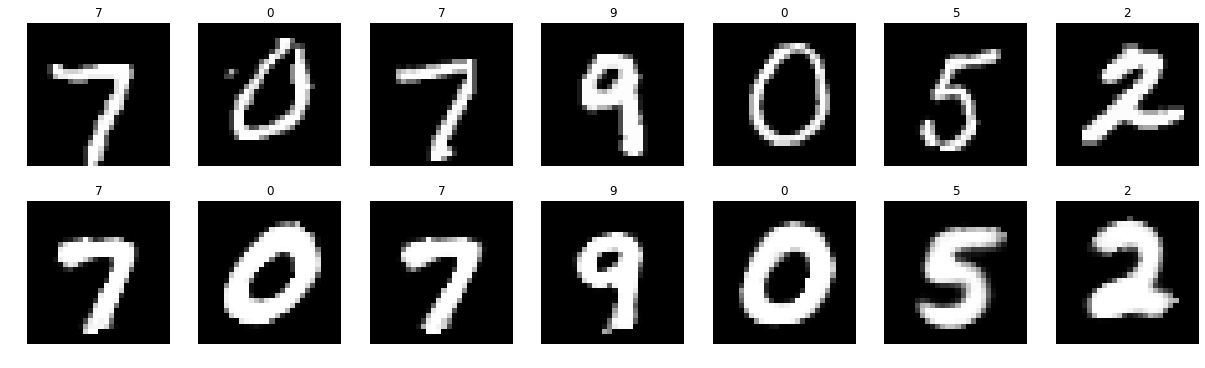

In [16]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

img_num = 7
k = random.randint(10,100)

imgs = x_test[k:img_num+k].cpu().numpy()
label = y_test[k:img_num+k].cpu().numpy()
pred_imgs,pred_label = model(x_test[k:img_num+k])
pred_imgs = pred_imgs.cpu().detach().numpy()
pred_label = pred_label.cpu().detach().numpy()
pred_label = np.argmax(pred_label,1)

plt.figure("test Image",figsize=(img_num*3,3*2))
for i in range(img_num):
    index = i
    img = imgs[index]
    title = label[index]
    img = img.reshape([28, 28])
    
    plt.subplot(2,img_num,i+1)
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
for i in range(img_num):
    index = i
    img = pred_imgs[index]
    plt.subplot(2,img_num,i+img_num+1)
    
    title = pred_label[index]
    img = img.reshape([28, 28])
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
filename = 'r1'+str(time.time())+'.jpg'
plt.savefig(filename)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


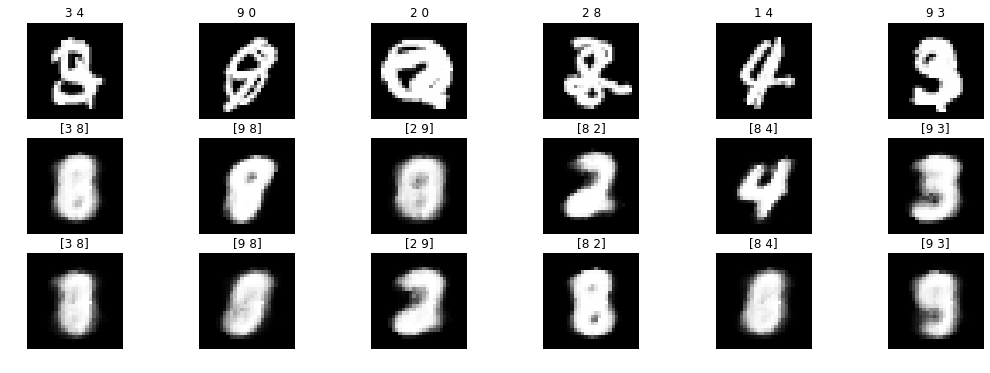

In [17]:
import random
k = random.randint(10,100)

img_num = 6
imgs = (torch.max(x_test[:img_num],x_test[k:img_num+k])).cpu().numpy()
label1 = (y_test[:img_num]).cpu().numpy()
label2 = (y_test[k:img_num+k]).cpu().numpy()

data = torch.tensor(imgs,dtype=torch.float,device=DEVICE)

is_over_lap = True
pred_imgs,pred_label = model(data)
is_over_lap = False


pred_imgs = pred_imgs.cpu().detach().numpy()
pred_label = pred_label.cpu().detach().numpy()
pred_label = np.argsort(pred_label,1)[:,-2:]


plt.figure("test Image",figsize=(img_num*3,3*2))
for i in range(img_num):
    index = i
    img = imgs[index]
    title = str(label1[index])+" "+str(label2[index])
    img = img.reshape([28, 28])
    
    plt.subplot(3,img_num,i+1)
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
for i in range(img_num):
    index = i
    img = pred_imgs[index]
    
    plt.subplot(3,img_num,i+img_num+1)
    
    title = pred_label[index]
    img = img[0,:,:]
    img = img.reshape([28, 28])
    plt.imshow(img,cmap=plt.cm.gray)    
    
    plt.axis('off') 
    plt.title(title)

for i in range(img_num):
    index = i
    img = pred_imgs[index]
    
    plt.subplot(3,img_num,i+2*img_num+1)
    
    title = pred_label[index]
    img = img[1,:,:]
    img = img.reshape([28, 28])
    plt.imshow(img,cmap=plt.cm.gray)    
    
    plt.axis('off') 
    plt.title(title)
    
filename = 'r2'+str(time.time())+'.jpg'
plt.savefig(filename)    
plt.show()